### Topics Covered

**Kubeflow Pipeline Building Demo - IRIS classifier Model training and prediction**
1. Python function needed to train and predict
2. Creating components from python functions
3. Initialise kubeflow pipeline
4. define the pipeline function and put together all the components
5. Mounting volume for component's output storage
6. Compiling pipeline and generating yaml - it can be directly uploaded to kubeflow and create experiments and runs using UI
7. Create run from pipeline function using the code
8. How to disable cache to see the each steps output on second and successive runs

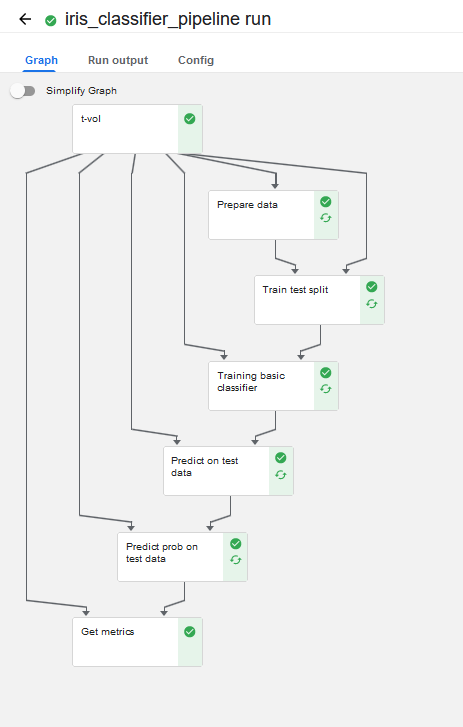

In [1]:
import kfp
import kfp.components as comp
import requests
import kfp.dsl as dsl

In [2]:
!pip show kfp

Name: kfp
Version: 1.8.18
Summary: KubeFlow Pipelines SDK
Home-page: https://github.com/kubeflow/pipelines
Author: The Kubeflow Authors
Author-email: 
License: UNKNOWN
Location: c:\users\ashutosh tripathi\appdata\roaming\python\python39\site-packages
Requires: absl-py, click, cloudpickle, Deprecated, docstring-parser, fire, google-api-core, google-api-python-client, google-auth, google-cloud-storage, jsonschema, kfp-pipeline-spec, kfp-server-api, kubernetes, protobuf, pydantic, PyYAML, requests-toolbelt, strip-hints, tabulate, typer, uritemplate
Required-by: 


In [3]:
def prepare_data():
    import pandas as pd
    print("---- Inside prepare_data component ----")
    # Load dataset
    df = pd.read_csv("https://raw.githubusercontent.com/TripathiAshutosh/dataset/main/iris.csv")
    df = df.dropna()
    df.to_csv(f'data/final_df.csv', index=False)
    print("\n ---- data csv is saved to PV location /data/final_df.csv ----")

In [4]:
def train_test_split():
    import pandas as pd
    import numpy as np
    from sklearn.model_selection import train_test_split
    print("---- Inside train_test_split component ----")
    final_data = pd.read_csv(f'data/final_df.csv')
    target_column = 'class'
    X = final_data.loc[:, final_data.columns != target_column]
    y = final_data.loc[:, final_data.columns == target_column]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,stratify = y, random_state=47)
    
    np.save(f'data/X_train.npy', X_train)
    np.save(f'data/X_test.npy', X_test)
    np.save(f'data/y_train.npy', y_train)
    np.save(f'data/y_test.npy', y_test)
    
    print("\n---- X_train ----")
    print("\n")
    print(X_train)
    
    print("\n---- X_test ----")
    print("\n")
    print(X_test)
    
    print("\n---- y_train ----")
    print("\n")
    print(y_train)
    
    print("\n---- y_test ----")
    print("\n")
    print(y_test)

In [5]:
def training_basic_classifier():
    import pandas as pd
    import numpy as np
    from sklearn.linear_model import LogisticRegression
    
    print("---- Inside training_basic_classifier component ----")
    
    X_train = np.load(f'data/X_train.npy',allow_pickle=True)
    y_train = np.load(f'data/y_train.npy',allow_pickle=True)
    
    classifier = LogisticRegression(max_iter=500)
    classifier.fit(X_train,y_train)
    import pickle
    with open(f'data/model.pkl', 'wb') as f:
        pickle.dump(classifier, f)
    
    print("\n logistic regression classifier is trained on iris data and saved to PV location /data/model.pkl ----")

In [6]:
def predict_on_test_data():
    import pandas as pd
    import numpy as np
    import pickle
    print("---- Inside predict_on_test_data component ----")
    with open(f'data/model.pkl','rb') as f:
        logistic_reg_model = pickle.load(f)
    X_test = np.load(f'data/X_test.npy',allow_pickle=True)
    y_pred = logistic_reg_model.predict(X_test)
    np.save(f'data/y_pred.npy', y_pred)
    
    print("\n---- Predicted classes ----")
    print("\n")
    print(y_pred)
    

In [7]:
def predict_prob_on_test_data():
    import pandas as pd
    import numpy as np
    import pickle
    print("---- Inside predict_prob_on_test_data component ----")
    with open(f'data/model.pkl','rb') as f:
        logistic_reg_model = pickle.load(f)
    X_test = np.load(f'data/X_test.npy',allow_pickle=True)
    y_pred_prob = logistic_reg_model.predict_proba(X_test)
    np.save(f'data/y_pred_prob.npy', y_pred_prob)
    
    print("\n---- Predicted Probabilities ----")
    print("\n")
    print(y_pred_prob)

In [8]:
def get_metrics():
    import pandas as pd
    import numpy as np
    from sklearn.metrics import accuracy_score,precision_score,recall_score,log_loss
    from sklearn import metrics
    print("---- Inside get_metrics component ----")
    y_test = np.load(f'data/y_test.npy',allow_pickle=True)
    y_pred = np.load(f'data/y_pred.npy',allow_pickle=True)
    y_pred_prob = np.load(f'data/y_pred_prob.npy',allow_pickle=True)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred,average='micro')
    recall = recall_score(y_test, y_pred,average='micro')
    entropy = log_loss(y_test, y_pred_prob)
    
    y_test = np.load(f'data/y_test.npy',allow_pickle=True)
    y_pred = np.load(f'data/y_pred.npy',allow_pickle=True)
    print(metrics.classification_report(y_test, y_pred))
    
    print("\n Model Metrics:", {'accuracy': round(acc, 2), 'precision': round(prec, 2), 'recall': round(recall, 2), 'entropy': round(entropy, 2)})

### Kubeflow pipeline creation work start from here

In [9]:
create_step_prepare_data = kfp.components.create_component_from_func(
    func=prepare_data,
    base_image='python:3.7',
    packages_to_install=['pandas==1.2.4','numpy==1.21.0']
)

In [10]:
create_step_train_test_split = kfp.components.create_component_from_func(
    func=train_test_split,
    base_image='python:3.7',
    packages_to_install=['pandas==1.2.4','numpy==1.21.0','scikit-learn==0.24.2']
)

In [11]:
create_step_training_basic_classifier = kfp.components.create_component_from_func(
    func=training_basic_classifier,
    base_image='python:3.7',
    packages_to_install=['pandas==1.2.4','numpy==1.21.0','scikit-learn==0.24.2']
)

In [12]:
create_step_predict_on_test_data = kfp.components.create_component_from_func(
    func=predict_on_test_data,
    base_image='python:3.7',
    packages_to_install=['pandas==1.2.4','numpy==1.21.0','scikit-learn==0.24.2']
)

In [13]:
create_step_predict_prob_on_test_data = kfp.components.create_component_from_func(
    func=predict_prob_on_test_data,
    base_image='python:3.7',
    packages_to_install=['pandas==1.2.4','numpy==1.21.0','scikit-learn==0.24.2']
)

In [14]:
create_step_get_metrics = kfp.components.create_component_from_func(
    func=get_metrics,
    base_image='python:3.7',
    packages_to_install=['pandas==1.2.4','numpy==1.21.0','scikit-learn==0.24.2']
)

In [23]:

# Define the pipeline
@dsl.pipeline(
   name='IRIS classifier Kubeflow Demo Pipeline',
   description='A sample pipeline that performs IRIS classifier task'
)
# Define parameters to be fed into pipeline
def iris_classifier_pipeline(data_path: str):
    vop = dsl.VolumeOp(
    name="t-vol",
    resource_name="t-vol", 
    size="1Gi", 
    modes=dsl.VOLUME_MODE_RWO)
    
    prepare_data_task = create_step_prepare_data().add_pvolumes({data_path: vop.volume})
    train_test_split = create_step_train_test_split().add_pvolumes({data_path: vop.volume}).after(prepare_data_task)
    classifier_training = create_step_training_basic_classifier().add_pvolumes({data_path: vop.volume}).after(train_test_split)
    log_predicted_class = create_step_predict_on_test_data().add_pvolumes({data_path: vop.volume}).after(classifier_training)
    log_predicted_probabilities = create_step_predict_prob_on_test_data().add_pvolumes({data_path: vop.volume}).after(log_predicted_class)
    log_metrics_task = create_step_get_metrics().add_pvolumes({data_path: vop.volume}).after(log_predicted_probabilities)

    
    prepare_data_task.execution_options.caching_strategy.max_cache_staleness = "P0D"
    train_test_split.execution_options.caching_strategy.max_cache_staleness = "P0D"
    classifier_training.execution_options.caching_strategy.max_cache_staleness = "P0D"
    log_predicted_class.execution_options.caching_strategy.max_cache_staleness = "P0D"
    log_predicted_probabilities.execution_options.caching_strategy.max_cache_staleness = "P0D"
    log_metrics_task.execution_options.caching_strategy.max_cache_staleness = "P0D"
    
    
    

In [24]:

kfp.compiler.Compiler().compile(
    pipeline_func=iris_classifier_pipeline,
    package_path='IRIS_Classifier_pipeline1.yaml')


In [25]:
client = kfp.Client()
#session_cookie = "MTY2MDY0Mjg0OXxOd3dBTkRSVE5FeElTMEZDVDFVeU5EZE1SMHhUVHpRMU5FcFpNMWRNVWpaTFVrOHlXRFJOVlRReVVFNUxOazFZVEVWQ05FUkZTRUU9fM7IcyOyK49OM0dMDjRJR85gqDksj-YOOLsagNs-_-KR"
# HOST = "http://localhost:8080/"
# namespace = "kubeflow"
# client = kfp.Client(
#     host=f"{HOST}/pipeline",
#     #cookies=f"authservice_session={session_cookie}",
#     namespace=namespace,
# )

In [26]:
DATA_PATH = '/data'

import datetime
print(datetime.datetime.now().date())


pipeline_func = iris_classifier_pipeline
experiment_name = 'iris_classifier_exp' +"_"+ str(datetime.datetime.now().date())
run_name = pipeline_func.__name__ + ' run'
namespace = "kubeflow"

arguments = {"data_path":DATA_PATH}

kfp.compiler.Compiler().compile(pipeline_func,  
  '{}.zip'.format(experiment_name))

run_result = client.create_run_from_pipeline_func(pipeline_func, 
                                                  experiment_name=experiment_name, 
                                                  run_name=run_name, 
                                                  arguments=arguments)

# from kubernetes import client as k8s_client
# pipeline_conf = kfp.dsl.PipelineConf()
# pipeline_conf.set_image_pull_secrets([k8s_client.V1ObjectReference(namespace='kubeflow', 
#                                                                                  name="secret")])
# pipeline_conf.set_image_pull_policy("IfNotPresent")
    
# Compile pipeline to generate compressed YAML definition of the pipeline.
# kfp.compiler.Compiler().compile(pipeline_func,  
#   '{}.zip'.format(experiment_name))

# Submit pipeline directly from pipeline function
# run_result = client.create_run_from_pipeline_func(pipeline_func, 
#                                                   experiment_name=experiment_name, 
#                                                   run_name=run_name, 
#                                                   arguments=arguments,
#                                                   namespace = namespace,
#                                                   pipeline_conf=pipeline_conf)







2022-12-24
